In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags, coo_matrix
from jax.experimental import sparse
import jax.numpy as jnp
import jax.random as random
from jax import lax, vmap
import jax


In [2]:
# exponential correlation function
def C_exponential(x,xi):
    """
        Exponential correlation function

        Parameters
        x : np.array
            Array of distance vectors (x1,x2,...,xn) of shape (N,d)
        xi : float
            Correlation length

    """
    # make sure this also works for d=1
    if len(x.shape) == 1:
        x = x.reshape(-1,1)
    return np.exp(-np.linalg.norm(x, axis=1)/xi)

In [95]:
def correlated_disorder(L,xi, seed=1000):
    
    """
        Generate two correlated Gaussian random fields with exponential correlation restrain in the interval [0,1]
        Parameters:
        L (int): The size of the grid (L+1 x L+1).
        xi (float): The correlation length.
        Returns:
        tuple: Two 2D numpy arrays representing the correlated Gaussian random fields.
    """

    x = np.arange(-L//2, L//2 + 1)
    y = np.arange(-L//2, L//2 + 1)
    X, Y = np.meshgrid(x, y)
    coords = np.vstack([X.ravel(), Y.ravel()]).T
   
    Cx = C_exponential(coords, xi).reshape(L+1, L+1)
    Ck_2d = np.fft.fft2(Cx)
    k_2d = np.fft.fftfreq(Cx.shape[0], d=1)
    Sk_2d = np.abs(Ck_2d)
    np.random.seed(seed)
    Gk_2d = np.random.normal(0, 1, Ck_2d.shape) * np.sqrt(Sk_2d)
    # inverse Fourier transform gives two real-valued Gaussian random fields (real and imaginary part)
    Gx_2d = np.fft.ifft2(Gk_2d)
    Gx1_2d = np.real(Gx_2d)
    Gx2_2d = np.imag(Gx_2d)
    Gx1_2d=Gx1_2d-np.min(Gx1_2d)
    Gx1_2d=Gx1_2d*1/np.max(Gx1_2d)
    Gx2_2d=Gx2_2d-np.min(Gx2_2d)
    Gx2_2d=Gx2_2d*1/np.max(Gx2_2d)
    
    return Gx1_2d,Gx2_2d
    

In [ ]:
def find_threshold_for_ratio(G, p, tol=1e-5):
    """
    Find the threshold value for which the ratio of elements in G less than the threshold
    is approximately equal to p.

    Parameters:
    G : np.ndarray
        The input array.
    p : float
        The desired ratio.
    tol : float
        The tolerance for the ratio.

    Returns:
    float
        The threshold value.
    """
    low, high = np.min(G), np.max(G)
    while high - low > tol:
        mid = (low + high) / 2
        ratio = np.sum(G < mid) / G.size
        if ratio < p:
            low = mid
        else:
            high = mid
    return (low + high) / 2

In [121]:

def generate_laplacian(N, conduction_block_threshold,xi, sparse_matrix=False):
    """
    Generate the Laplacian matrix for a grid graph with conduction blocks given by correlated disorder.
    parameters:
    N : int
        The size of the grid (N x N).
    conduction_block_threshold : float in [0, 1]
        The threshold for conduction blocks.
    xi : float
        The correlation length of the disorder.
    sparse_matrix : bool
        Whether to return a sparse matrix.
    returns:
    scipy.sparse.coo_matrix or np.ndarray
        The Laplacian matrix.
    np.ndarray
        The conduction blocks.  
    """
    num_nodes = N * N
    adj_rows = []
    adj_cols = []
    adj_data = []
    Gx, G2=correlated_disorder(N-1,xi)

    conduction_blocks = Gx.reshape(N, N) < find_threshold_for_ratio(Gx, conduction_block_threshold)


    # Function to map grid (i, j) to a single node index
    def node_index(i, j):
        return i * N + j

    # Define neighbors for the nine-point stencil with weights
    neighbors = [
        (-1, 0, .5),     # up
        (1, 0, .5),      # down
        (0, -1, .5),     # left
        (0, 1, .5),      # right
        (-1, -1, .25),   # top-left
        (-1, 1, .25),    # top-right
        (1, -1, .25),    # bottom-left
        (1, 1, .25)      # bottom-right
    ]
    
    # Build adjacency structure excluding conduction blocks
    indices = np.array([[i, j] for i in range(N) for j in range(N)])
    idx = node_index(indices[:, 0], indices[:, 1])

    for di, dj, weight in neighbors:
        ni = indices[:, 0] + di
        nj = indices[:, 1] + dj

    # Step 1: Filter for in-bounds neighbors
        in_bounds = (ni >= 0) & (ni < N) & (nj >= 0) & (nj < N)
    
    # Step 2: Find valid indices (in-bounds) to avoid shape mismatches
        valid_indices = np.where(in_bounds)[0]
        ni_valid = ni[valid_indices]
        nj_valid = nj[valid_indices]

    # Step 3: Apply conduction block exclusion on the filtered indices
        valid_conduction = ~conduction_blocks[ni_valid, nj_valid]
        valid_node = ~conduction_blocks[indices[valid_indices, 0], indices[valid_indices, 1]]
        valid = valid_conduction & valid_node

    # Step 4: Append data for fully valid connections
        adj_rows.extend(idx[valid_indices][valid])
        adj_cols.extend(node_index(ni_valid[valid], nj_valid[valid]))
        adj_data.extend([weight] * int(np.sum(valid)))


    # Create adjacency and degree matrices
    adj_matrix = coo_matrix((adj_data, (adj_rows, adj_cols)), shape=(num_nodes, num_nodes))
    degrees = np.array(adj_matrix.sum(axis=1)).flatten()
    degree_matrix = diags(degrees)

    # Construct Laplacian matrix
    laplacian_matrix = degree_matrix - adj_matrix


    if sparse_matrix:

        return sparse.BCSR.from_scipy_sparse(laplacian_matrix), jnp.array(conduction_blocks)
    
    else:
        return laplacian_matrix.todense(), conduction_blocks



In [73]:

def FHN_step(u, v, N, a, b, e, Du, sigma, L, key, delta_t):
    '''
    Perform a single step of the noisy FitzHugh-Nagumo model.
    Parameters:
    - u: state variable u
    - v: state variable v
    - N: number of nodes
    - a: parameter a
    - b: parameter b
    - e: parameter e giving the timescale separation between u and v
    - Du: Diffusion coefficient
    - sigma: noise intensity
    - L: Laplacian matrix
    - key: random key for noise generation
    - delta_t: time step
    Returns:
    - u_new: updated state variable u
    - v_new: updated state variable v
    '''
    # Generate Gaussian noise for each element of h
    noise = random.normal(key, u.shape)
    
    du = a * u * (u - b) * (1 - u) - Du * (L @ u) - v 
    dv = e * (u - v)
    u_new = u + du * delta_t + jnp.sqrt(delta_t * sigma**2) * noise
    v_new = v + dv * delta_t

    return u_new, v_new

def run_simulation(N, y0='wave', a=3, b=0.05, e=1e-2, Du=0.04, L=None, c1=None, sigma=0.0001, stimulus_time=1000, delta_t=0.1, total_time=3000.0, Nconf=3000, key=random.PRNGKey(2)):
    indices = jnp.where((jnp.arange(N) % 200 == 0) & (c1.flatten() == 0))[0]
    if y0 == 'wave':
        y0 = jnp.zeros(2 * N, dtype=jnp.float32)
        y0 = y0.at[indices].set(0.1)

    # Calculate the number of steps based on the total time and delta_t
    num_steps = int(total_time / delta_t)
    save_interval = num_steps // Nconf
    
    # Initialize state variables
    u = y0[:N]
    v = y0[N:]

    def scan_fn(carry, step):
        u, v, key, save_counter, u_saved, v_saved = carry
        key, subkey = random.split(key)
        
        # Apply stimulus to the specified indices
        u = jax.lax.cond((step > 0) & (step % int(stimulus_time / delta_t) == 0),
                          lambda u: u.at[indices].add(0.1),
                          lambda u: u,
                          u)

        u, v = FHN_step(u, v, N, a, b, e, Du, sigma, L, subkey, delta_t)
        
        # Save the configuration at the specified intervals
        save_counter = save_counter + 1
        u_saved = jax.lax.cond(save_counter % save_interval == 0,
                               lambda u_saved: u_saved.at[save_counter // save_interval - 1].set(u),
                               lambda u_saved: u_saved,
                               u_saved)
        v_saved = jax.lax.cond(save_counter % save_interval == 0,
                               lambda v_saved: v_saved.at[save_counter // save_interval - 1].set(v),
                               lambda v_saved: v_saved,
                               v_saved)
        
        return (u, v, key, save_counter, u_saved, v_saved), (u, v)

    # Preallocate arrays for saved configurations
    u_saved = jnp.zeros((Nconf, N), dtype=jnp.float32)
    v_saved = jnp.zeros((Nconf, N), dtype=jnp.float32)
    
    # Create a range of steps
    steps = jnp.arange(num_steps)
    
    # Run the scan function
    carry = (u, v, key, 0, u_saved, v_saved)
    carry, _ = lax.scan(scan_fn, carry, steps)

    u_saved = carry[4]
    v_saved = carry[5]

    return u_saved, v_saved

In [122]:

L1, c1= generate_laplacian(200, 0.45, 2, sparse_matrix=True)

In [123]:
u_sol_health, v_sol_health = run_simulation(N=200*200, sigma=0.0001,L=L1, c1=c1,Du=0.04, a=3, key=random.PRNGKey(2),delta_t=0.1, total_time=2600, stimulus_time=2600, Nconf=2600)

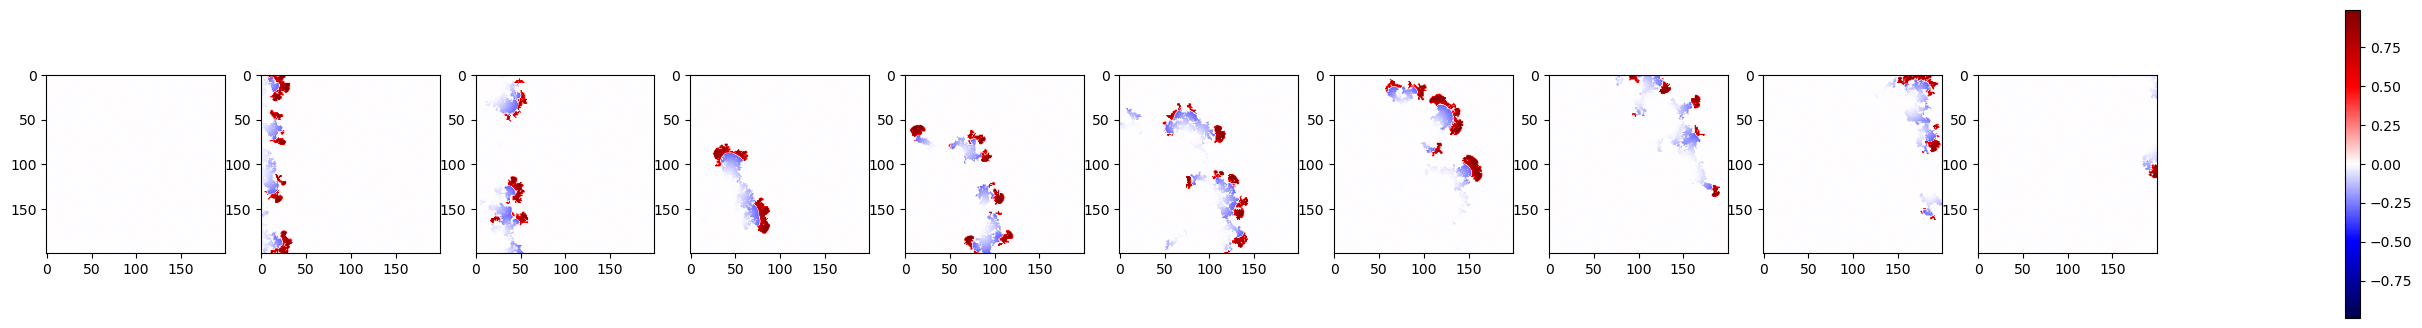

In [ ]:
fig, axs = plt.subplots(1,11,figsize=(30,4))
min = -np.abs(u_sol_health).max()
max = u_sol_health.max()
for i, ax in enumerate(axs[:-1]):
    im = ax.imshow(u_sol_health[int((i/len(axs)*2600)),:200].reshape(200,200),cmap='seismic', interpolation='bilinear', vmin=min,vmax=max)
axs[-1].axis('off')
fig.colorbar(im, ax=axs[-1])